<a href="https://colab.research.google.com/github/guscassiano/Transfer_Learning_Dio_bootcamp/blob/main/Cats-vs-Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Treinamento com um Dataset Amplo – Gatos vs Cachorros

Este laboratório utiliza uma base já existente tendo somente a última camada retirada para que possamos treinar com novos dados, estou utilizando o database do Kaggle - Cats and Dogs, que possui 12.500 imagens por classe. O objetivo é treinar uma rede neural eficiente e avaliar seu desempenho em dados inéditos.

In [6]:
# Download + descompactar dataset
!wget --no-check-certificate \
 "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip" \
 -O "/tmp/cats-dogs.zip"

import zipfile
with zipfile.ZipFile("/tmp/cats-dogs.zip", "r") as zip_ref:
    zip_ref.extractall("/tmp")

--2025-07-17 23:21:38--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.63.210.18, 2600:1406:5e00:484::317f, 2600:1406:5e00:48e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.63.210.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-dogs.zip’

/tmp/cats-dogs.zip  100%[===================>] 786.67M   118MB/s    in 6.9s    

2025-07-17 23:21:45 (114 MB/s) - ‘/tmp/cats-dogs.zip’ saved [824887076/824887076]



In [7]:
# Importando libs e modelo VGG16 pré-treinado
import os
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [9]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]


    os.makedirs(TRAINING, exist_ok=True)
    os.makedirs(TESTING, exist_ok=True)

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [10]:
# Preparando geradores de dados
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
# Construir o modelo com VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Treinamento
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
533/703 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.8884 - loss: 1.6474

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


703/703 ━━━━━━━━━━━━━━━━━━━━ 186s 251ms/step - accuracy: 0.8973 - loss: 1.4320 - val_accuracy: 0.9651 - val_loss: 0.1907
Epoch 2/10
  1/703 ━━━━━━━━━━━━━━━━━━━━ 1:02 90ms/step - accuracy: 1.0000 - loss: 0.0493

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 1.0000 - loss: 0.0493 - val_accuracy: 0.9647 - val_loss: 0.1932
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 202s 277ms/step - accuracy: 0.9502 - loss: 0.1975 - val_accuracy: 0.9663 - val_loss: 0.1064
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9062 - loss: 0.2478 - val_accuracy: 0.9663 - val_loss: 0.1070
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 233s 246ms/step - accuracy: 0.9578 - loss: 0.1230 - val_accuracy: 0.9736 - val_loss: 0.0900
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9732 - val_loss: 0.0901
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 202s 257ms/step - accuracy: 0.9603 - loss: 0.1078 - val_accuracy: 0.9724 - val_loss: 0.0863
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9688 - loss: 0.0598 - val_accuracy: 0.9724 - val_loss: 0.0861
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 202s 287ms/step - accuracy: 0.9671 - loss: 0.0872 - val_ac

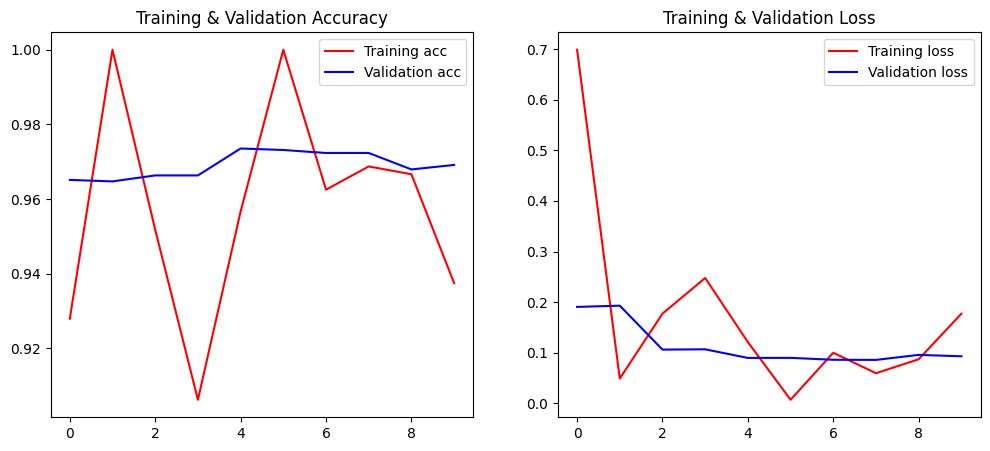

In [13]:
# Visualização dos resultados
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [15]:
# Importando funções e libs para testar a mão o funcionamento
from google.colab import files
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Saving golden.jpg to golden (1).jpg


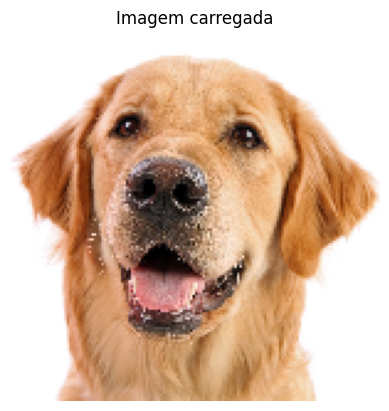

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predição: CACHORRO 🐶 (0.52)


In [21]:
# Fazer upload da imagem
uploaded = files.upload()

for fn in uploaded.keys():
    # Caminho da imagem
    path = fn

    # Carrega a imagem no tamanho esperado pelo VGG16
    img = image.load_img(path, target_size=(150, 150))  # mesmo tamanho usado no treinamento

    # Mostra a imagem
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.title("Imagem carregada")
    plt.show()

    # Pré-processa a imagem
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # normalização igual ao treinamento

    # Predição
    prediction = model.predict(x)

    if prediction[0] > 0.5:
        print(f"Predição: CACHORRO 🐶 ({prediction[0][0]:.2f})")
    else:
        print(f"Predição: GATO 🐱 ({prediction[0][0]:.2f})")